## Уменьшение размерности(manifold)


In [25]:
from time import time
import numpy as np
from sklearn import manifold

import matplotlib.pyplot as plt
%matplotlib inline

### Загружаем MNIST
 * Если кто не знает, это выборка рукописных цифер

In [2]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape


In [3]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


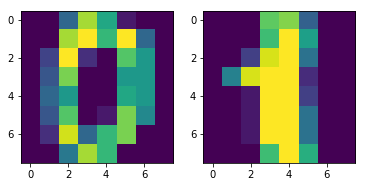

In [4]:
# a few testimonials
plt.subplot(1,2,1)
plt.imshow(X[0].reshape(8,8))
plt.subplot(1,2,2)
plt.imshow(X[1].reshape(8,8))

### Визуализация данных

Для начала возьмём случайную пару проекций

In [5]:
from matplotlib import offsetbox
def plot_embedding(X,y=None,ax=None,show_images=True,min_dist=5e-3,figsize=[12,10]):
    
    #нормализуем данные
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.subplot(1,1,1)

    # рисуем scatter
    if y is None:
        plt.scatter(*X.T)
    else:
        assert y is not None
        #рисуем циферки a-la scatter
        for i in range(X.shape[0]):
            ax.text(X[i, 0], X[i, 1], str(y[i]),
                     color= plt.cm.Set1(y[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 9})

    if not show_images:
        return
        
    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < min_dist: continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
            X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])


### GaussianRandomProjection
 * Выбирает несколько (2) случайных осей в многомерном пространстве данных
 * проецирует выборку на эти оси
 * Сам по себе довольно бесполезен

In [6]:
from sklearn.random_projection import GaussianRandomProjection

Xrp = GaussianRandomProjection(n_components=2).fit_transform(X)

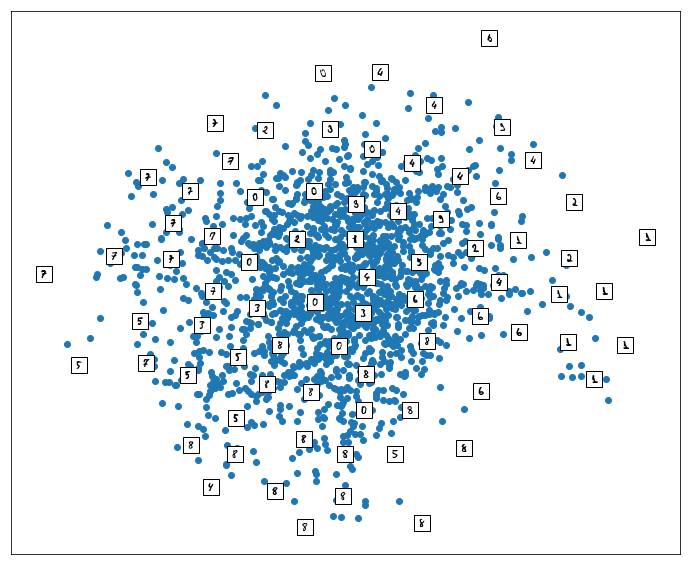

In [7]:
plot_embedding(Xrp)

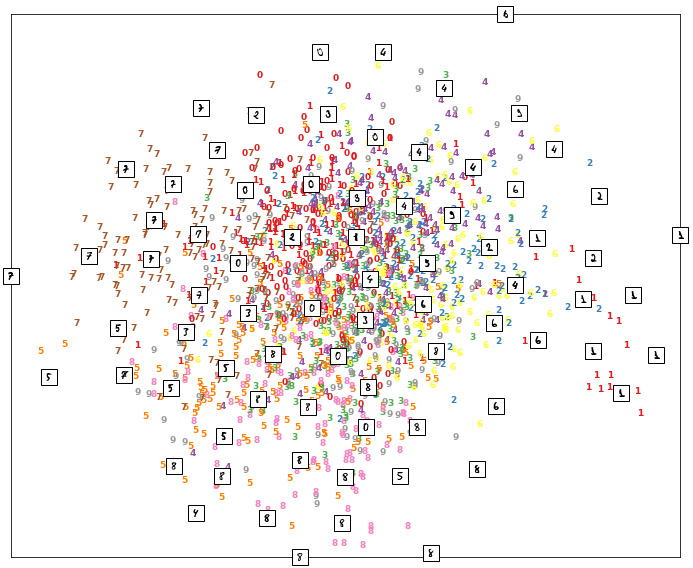

In [8]:
plot_embedding(Xrp,y)

После перезапуска Xrp=... результат может поменяться

### Singular Value Decomposition

* Идея: мы пытаемся отобразить данные на такие оси, с которых их потом можно восстановить с минимальными потерями
* Количество этих "новых осей" обычно меньше, чем у изначальных данных

In [9]:
from sklearn.decomposition import TruncatedSVD

In [10]:
svd = TruncatedSVD(n_components=2)
Xsvd = svd.fit_transform(X)

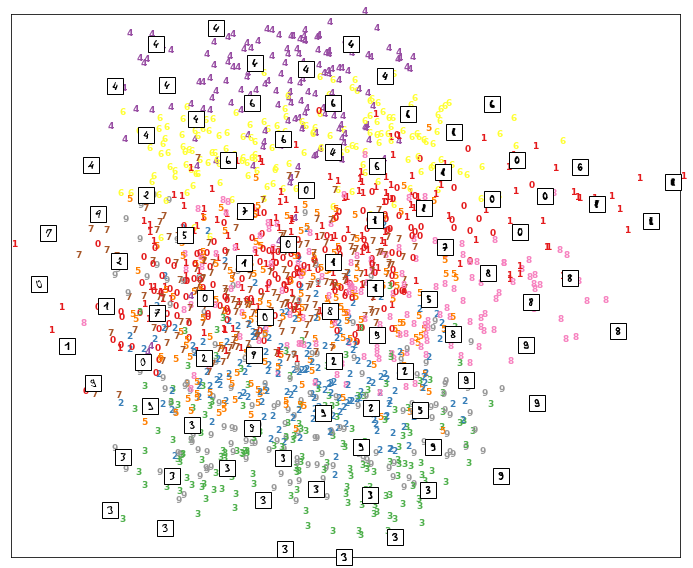

In [11]:
plot_embedding(Xsvd[:,:2],y)

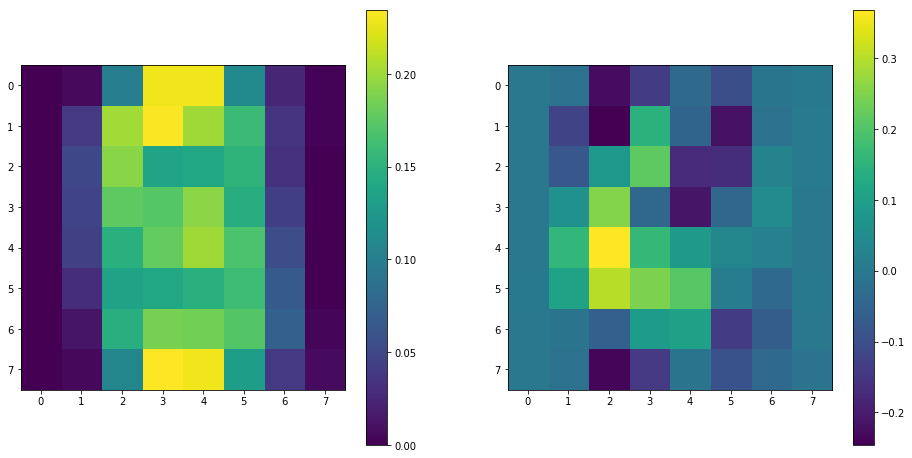

In [12]:
n = svd.n_components
plt.figure(figsize=[16,8])
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(svd.components_[i].reshape(8,8),
              interpolation='none')
    plt.colorbar()


### PCA ака анализ главных компонент
* Идея: мы пытаемся найти оси, вдоль которых расположены данные
* Опять же, количество таких осей меньше, чем в оригинальных данных

__По коду крайне похоже на SVD__ , засим предлагаю применить его самостоятельно

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

Xpca = pca.fit_transform(X)

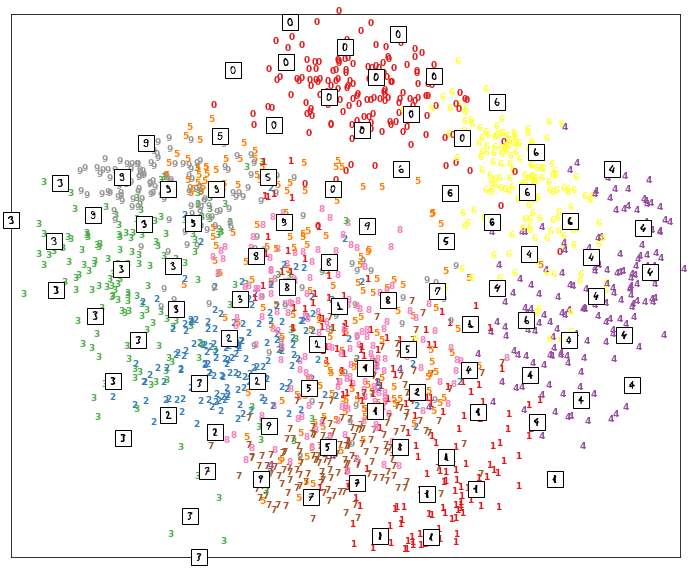

In [14]:
plot_embedding(Xpca,y)

#### В этот момент хорошей идеей будет сравнить 3 полученные картинки

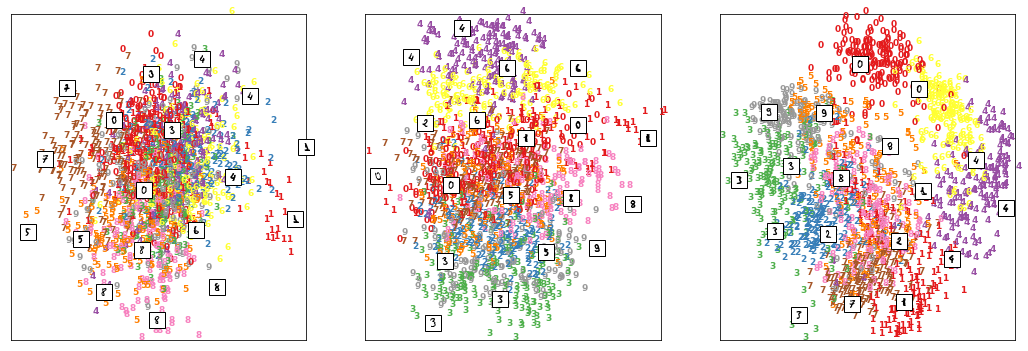

In [15]:
plt.figure(figsize=[18,6])
plot_embedding(Xrp,y,ax=plt.subplot(1,3,1),min_dist=3e-2)
plot_embedding(Xsvd,y,ax=plt.subplot(1,3,2),min_dist=3e-2)
plot_embedding(Xpca,y,ax=plt.subplot(1,3,3),min_dist=3e-2)

# LDA aka Linear Discriminant Analysis

* Идея: давайте найдём такие оси, на которых классы (циферки) будут лучше всего разделены
* На самом деле, это самый обычный классификатор, уменьшение размерности - просто побочный эффект

* Интерфейс такой же, как предыдущие, но поскольку этот метод разделяет __классы__, ему нужно отдать, собственно, классы(__y__), а не только признаки(__X__).

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
Xlda = lda.fit_transform(X, y)

/home/maximus/anaconda3/envs/cs/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


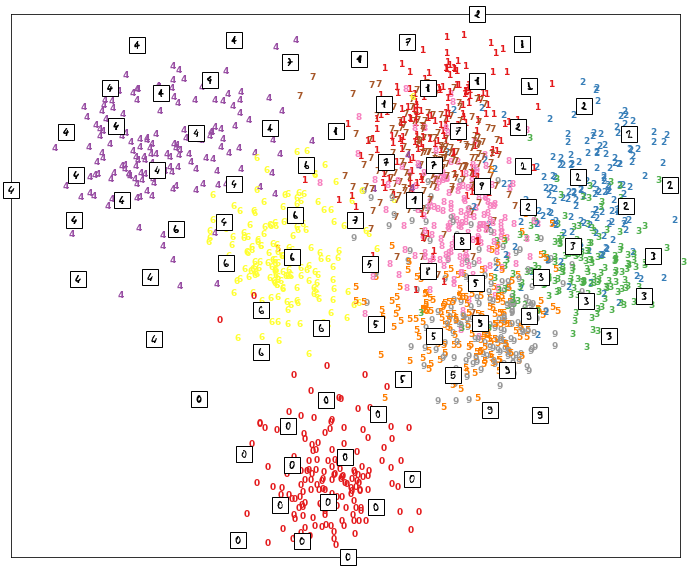

In [17]:
plot_embedding(Xlda,y)

# Embedding ака Manifold learning

* В отличие от предыдущих не имеют ограничений вида "только линейное"/"квадратичное"/"синусоидальное" преобразование

* Общая идея: давайте мы попытаемся сопоставить каждой точке в данных новые координаты такие, чтобы "было хорошо"

* Что такое хорошо и как сопоставлять - зависит от конкретного метода

### Multidimensional Scaling

* Идея - давайте расположим новые точки так, чтобы близкие в многомерном пространстве точки получили близки друг к другу координаты, а удалённые - соответственно, далёкие друг от друга

#####  Чуть сложнее
* Давайте зададим точкам такие новые координаты, чтобы попарные расстояния сохранялись как можно точнее.
  * Есть точки в 64-мерном пространстве. Между ними есть расстояние, например
$$ r(a,b) = \sqrt { (a_0 - b_0)^2 + (a_1 - b_1)^2 + ... + (a_{63} - b_{63})^2}$$
  * Есть наши новые точки в двумерном пространстве, между ними есть расстояние
$$ r_{new}(a',b') = \sqrt { (a'_x - b'_x)^2 + (a'_y - b'_y)^2 } $$

  * Хотим, чтобы $r_{new}$ было максимально близко к $r$
  * Двигаем новые точки так, чтобы в среднем по всем a,b
$$ r_{new}(a',b') - r(a,b) \to min $$

  * Далее по тексту разладка между старым и новым расстоянием называется __stress__

In [18]:
from sklearn.manifold import MDS
mds = MDS(n_components=2,verbose=2,n_init=1)
Xmds = mds.fit_transform(X)

it: 0, stress 3799532072.2760973
it: 1, stress 770194728.2673639
it: 2, stress 751948536.6415273
it: 3, stress 738750630.9519275
it: 4, stress 728331358.1159115
it: 5, stress 719881713.0886813
it: 6, stress 712919655.856725
it: 7, stress 707144050.0519145
it: 8, stress 702311272.341719
it: 9, stress 698191611.8263086
it: 10, stress 694621001.0035467
it: 11, stress 691496311.2496836
it: 12, stress 688763164.7902536
it: 13, stress 686346362.0187937
it: 14, stress 684168054.498676
it: 15, stress 682163132.7076154
it: 16, stress 680263061.0955851
it: 17, stress 678427299.304982
it: 18, stress 676633632.6377206
it: 19, stress 674853131.0525913
it: 20, stress 673068758.3387412
it: 21, stress 671259513.0594475
it: 22, stress 669421631.4106115
it: 23, stress 667535450.5541039
it: 24, stress 665572221.903204
it: 25, stress 663514003.6593744
it: 26, stress 661344927.4221771
it: 27, stress 659032511.7862327
it: 28, stress 656561443.4630804
it: 29, stress 653908156.4824924
it: 30, stress 651070205

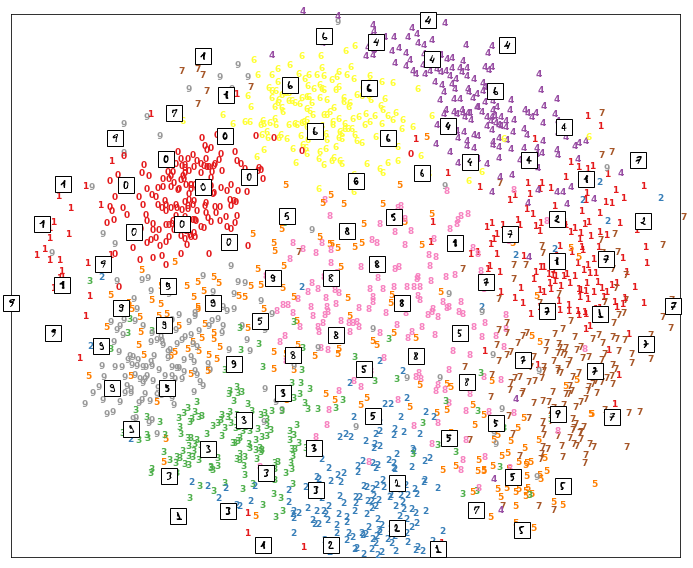

In [19]:
plot_embedding(Xmds,y)

# t-SNE
t-distributed Stochasitc Neiborhood Embedding бла-бла-бла

* Идейно похож на MDS, но чуть более пофигист - ему плевать на далёкие точки.

* Хотим, чтобы сохранялось расстояние до K ближайших соседей, остальные - как повезёт

Иными словами, хотим как можно лучше сохранить отношение соседства, забивая на глобальную структуру.

In [20]:
from sklearn.manifold import TSNE

In [21]:
%%time
tsne = TSNE(n_components=2)
Xtsne = tsne.fit_transform(X)

CPU times: user 38 s, sys: 1.99 s, total: 40 s
Wall time: 40 s


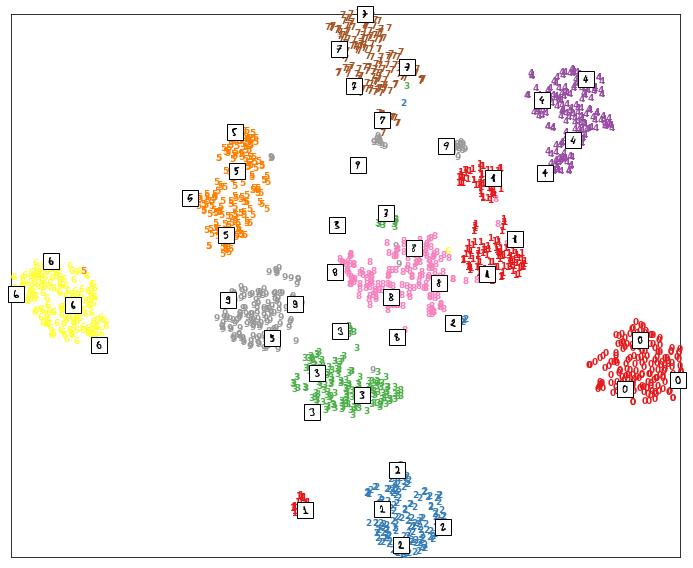

In [22]:
plot_embedding(Xtsne,y)

# Так кто же лучше?
 * t-SNE зависит от параметра perplexity - на сколько ближайших соседей смотреть (доля)
   * Посмотрите, как результат меняется при изменении perplexity от 1 до 100
   * Все точки брать не обязательно, опорных значений вида [1,5,...50,100] должно хватить 
 


In [ ]:
<посмотри, как меняется картинка tSNE в зависимости от перплексии>

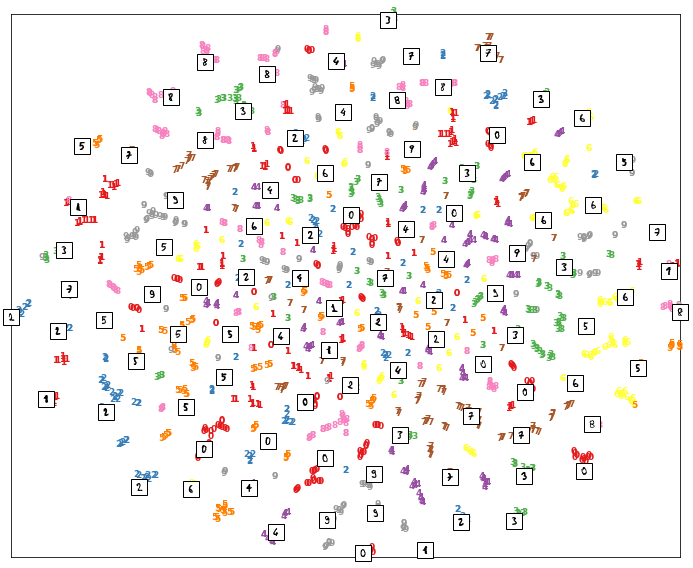

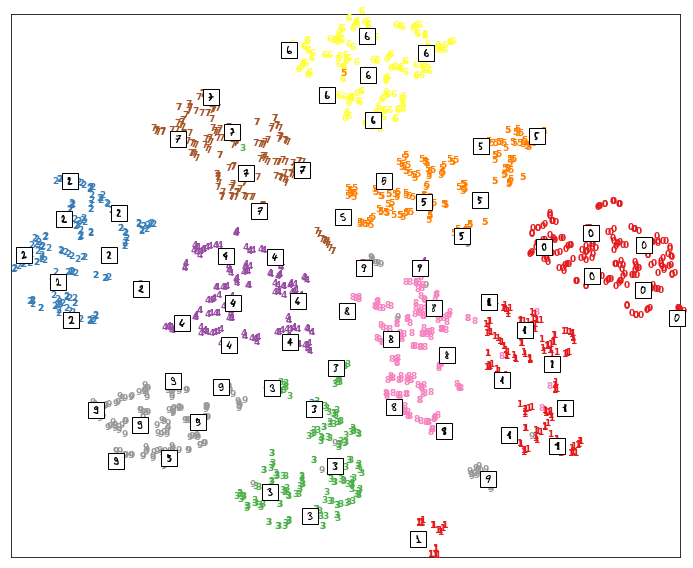

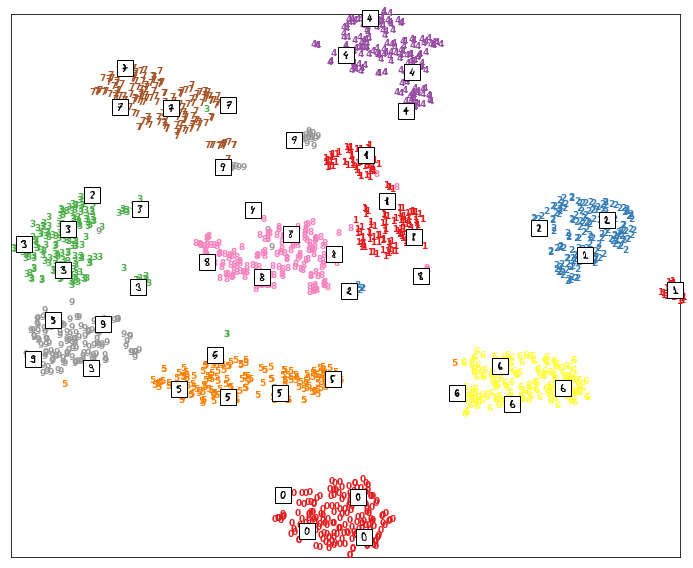

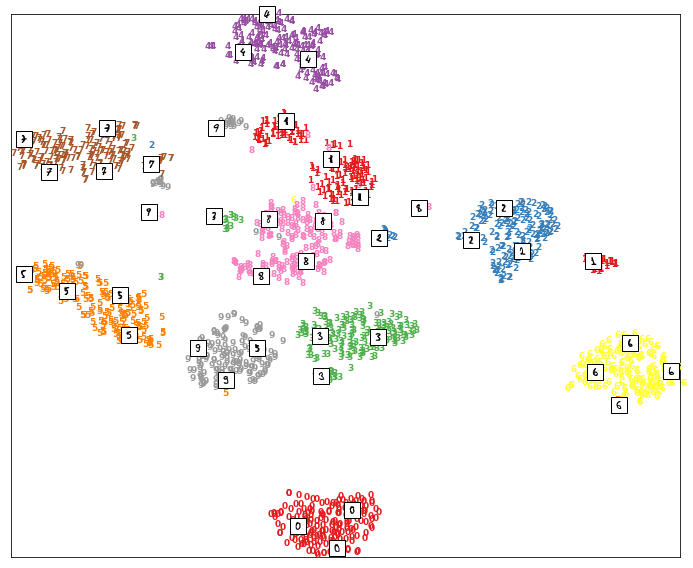

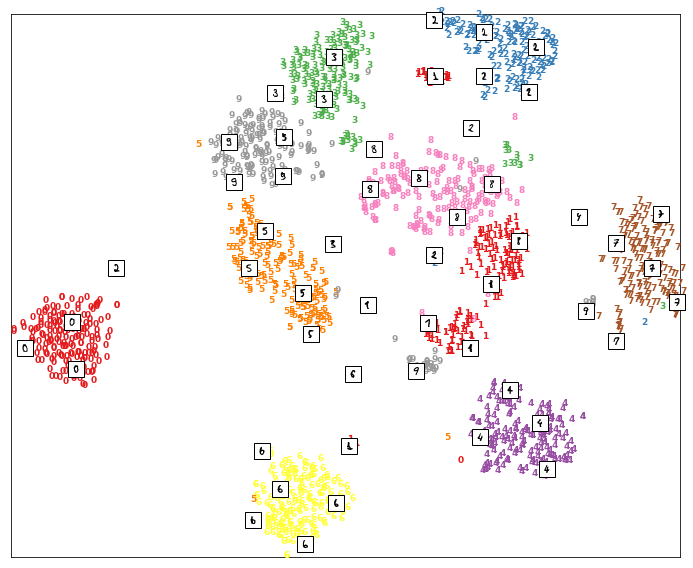

In [48]:
for i in [1,5,25,50,100]:
    tsne = TSNE(n_components=2, perplexity=i)
    Xtsne = tsne.fit_transform(X)
    plot_embedding(Xtsne,y)

 * Попробуйте сперва выделить несколько главных компонент с PCA, и только потом применить TSNE
   * Для начала, 64D изначально -> 16D после PCA -> 2D после TSNE


In [ ]:
<PCA_или_LDA->tsne>

 * Попробуйте схожие методы - Isomap, LocallyLinearEmbedding или SpectralEmbedding
   * Все лежат в sklearn.manifold

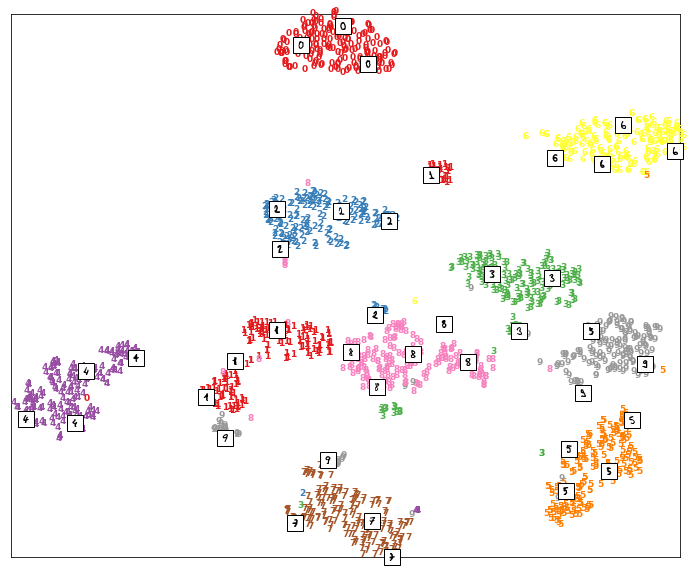

In [28]:
pca = PCA(n_components=16)
new_X = pca.fit_transform(X)
new_X = tsne.fit_transform(new_X, y)
plot_embedding(new_X, y)

In [37]:
n_components = 2
n_neighbors = 20
se = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
Xse = se.fit_transform(X)

#Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)

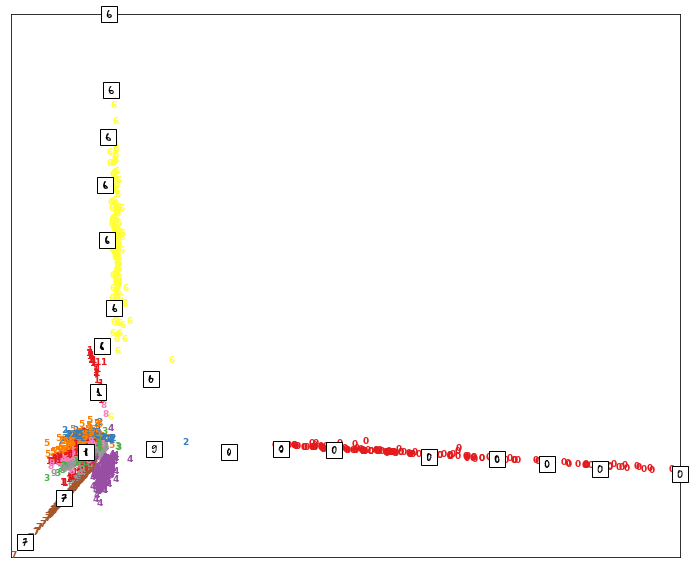

In [38]:
plot_embedding(Xse, y)

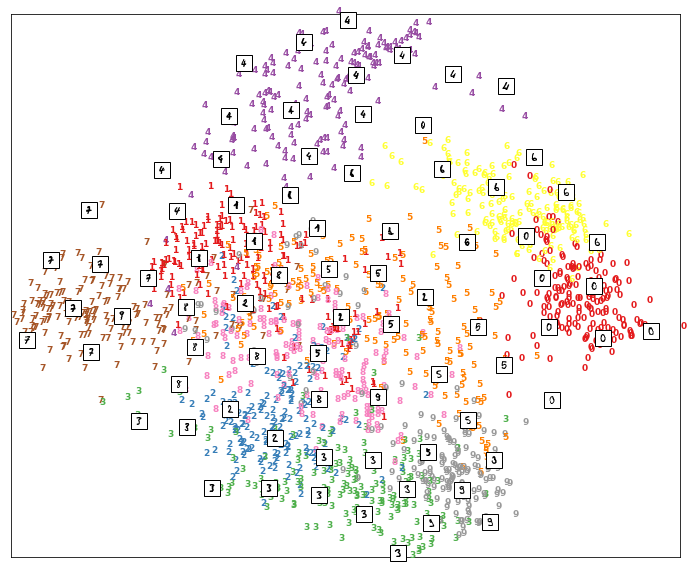

In [34]:
n_components = 2
n_neighbors = 50
se = manifold.Isomap(n_components=n_components, n_neighbors=n_neighbors)
Xiso = se.fit_transform(X)
plot_embedding(Xiso, y)

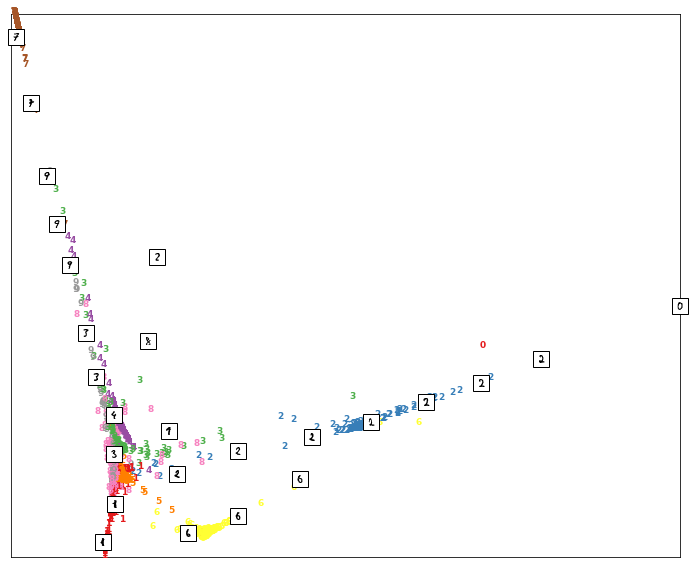

In [41]:
n_components = 2
n_neighbors = 8
lle = manifold.LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
Xlle = lle.fit_transform(X)
plot_embedding(Xlle, y)